In [10]:
import pandas as pd
import numpy as np
from pandas import json_normalize
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.family'] = 'Times New Roman'

In [3]:
class CFG:
    input_dir = "../input"
    output_dir = "../output"
    random_seed = 42
    exp_no = "exp000"

In [4]:
train_df = pd.read_csv(f"{CFG.input_dir}/chapter2_demo_data_postprocess.csv")
train_df

,サンプルID,サンプル名,サンプル作成日,担当者,備考,溶媒１,溶媒2,溶媒3,添加剤1,添加剤2,...,乾燥方式,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性(n10,画像濃度,粘度,表面張力,保存後粘度
0,DP_001,界1_1.5,2024/1/19,高岡,界面活性剤1水準振り,47.4,40,0,2,0,...,0,25,NaN,10,5,0.4,1.07,9,38,NaN
1,DP_002,界1_1.2,2024/1/19,高岡,界面活性剤1水準振り,47.7,40,0,2,0,...,0,25,NaN,10,5,0.4,1.07,9,40,NaN
2,DP_003,界1_1.0,2024/1/19,高岡,界面活性剤1水準振り,47.9,40,0,2,0,...,0,25,NaN,10,5,0.4,1.08,9,41,NaN
3,DP_004,界1_0.5,2024/1/19,高岡,界面活性剤1水準振り,48.4,40,0,2,0,...,0,25,NaN,10,5,0.4,1.09,9,44,NaN
4,DP_005,界1_1.5_樹1_4.0_ref,2024/1/30,福原,ref,47.4,40,0,2,0,...,0,25,NaN,10,5,0.7,1.07,9,38,NaN
5,DP_006,界2_1.5_樹1_4.0,2024/1/30,福原,界面活性剤1種類検討,47.4,40,0,2,0,...,0,25,NaN,10,5,0.7,1.05,9,37,NaN
6,DP_007,界3_1.5_樹1_4.0,2024/1/30,福原,界面活性剤1種類検討,47.4,40,0,2,0,...,0,25,NaN,10,5,0.7,1.02,9,39,NaN
7,DP_008,界1_1.5_樹1_6.0,2024/1/30,福原,定着樹脂１水準振り,45.4,40,0,2,0,...,0,25,NaN,10,5,1.1,1.07,10,36,NaN
8,DP_009,界1_1.5_樹1_8.0,2024/1/30,福原,定着樹脂１水準振り,43.4,40,0,2,0,...,0,25,NaN,10,5,1.6,1.07,11,34,NaN
9,DP_010,界1_1.5_樹1_10.0,2024/1/30,福原,定着樹脂１水準振り,41.4,40,0,2,0,...,0,25,NaN,10,5,2.0,1.07,13,32,NaN


In [5]:
# train_dfの列名をリストで取得
columns = train_df.columns
# train_dfの列名を表示
columns

Index(['サンプルID', 'サンプル名', 'サンプル作成日', '担当者', '備考', '溶媒１', '溶媒2', '溶媒3', '添加剤1',
       '添加剤2', '界面活性剤１', '界面活性剤２', '界面活性剤３', '顔料１', '顔料２', '定着樹脂１', '定着樹脂２',
       '防腐剤', '塗布量', '乾燥方式', '乾燥温度', '乾燥時間', '擦過回数', '擦過圧力', '耐擦過性(n10',
       '画像濃度', '粘度', '表面張力', '保存後粘度'],
      dtype='object')

In [6]:
# 欠損のある列を表示
train_df.isnull().sum()

サンプルID       0
サンプル名        0
サンプル作成日      0
担当者          0
備考           0
溶媒１          0
溶媒2          0
溶媒3          0
添加剤1         0
添加剤2         0
界面活性剤１       0
界面活性剤２       0
界面活性剤３       0
顔料１          0
顔料２          0
定着樹脂１        0
定着樹脂２        0
防腐剤          0
塗布量          0
乾燥方式         0
乾燥温度         0
乾燥時間        12
擦過回数         0
擦過圧力         0
耐擦過性(n10     0
画像濃度         0
粘度           0
表面張力         0
保存後粘度       20
dtype: int64

In [8]:
numeric_parameter_cols = [
    # 'サンプルID', 'サンプル名', 'サンプル作成日', '担当者', '備考', 
    '溶媒１', '溶媒2', '溶媒3', '添加剤1','添加剤2', '界面活性剤１', '界面活性剤２', '界面活性剤３',
    '顔料１', '顔料２', '定着樹脂１', '定着樹脂２','防腐剤', '塗布量', '乾燥方式', '乾燥温度', 
    # '乾燥時間',
    '擦過回数', '擦過圧力',
    # '耐擦過性(n10','画像濃度', '粘度', '表面張力', '保存後粘度'
    ]

In [11]:
train_X = train_df[numeric_parameter_cols]
objective_cols = ['耐擦過性(n10']
train_Y = train_df[objective_cols]

0it [00:00, ?it/s]

/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([0], dtype='int64')
RMSE_train: 0.845578608465284
MAE_train: 0.5921888726382779
R2_train: 0.8298430411211053
Int64Index([1], dtype='int64')
RMSE_train: 0.8463670555534413
MAE_train: 0.5924979937722032
R2_train: 0.8295255725734356


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([2], dtype='int64')
RMSE_train: 0.8466160572354731
MAE_train: 0.5924565351805413
R2_train: 0.8294252504659791


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([3], dtype='int64')
RMSE_train: 0.8467107277621563
MAE_train: 0.5913763559580305
R2_train: 0.8293871002227498
Int64Index([4], dtype='int64')
RMSE_train: 0.8480100250202164
MAE_train: 0.5982226363758689
R2_train: 0.8309043429631386
Int64Index([5], dtype='int64')
RMSE_train: 0.8448572274698606
MAE_train: 0.58345154815255
R2_train: 0.8321593595595829


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([6], dtype='int64')
RMSE_train: 0.8448572274698606
MAE_train: 0.5834515481525501
R2_train: 0.8321593595595829
Int64Index([7], dtype='int64')
RMSE_train: 0.8476988434449023
MAE_train: 0.5967373443789675
R2_train: 0.8332881872093686


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([8], dtype='int64')
RMSE_train: 0.8473231892326092
MAE_train: 0.5964022371307575
R2_train: 0.8355723121459094
Int64Index([9], dtype='int64')
RMSE_train: 0.8470819334575871
MAE_train: 0.5947475455761468
R2_train: 0.8368601139021159
Int64Index([10], dtype='int64')
RMSE_train: 0.8439663544453774
MAE_train: 0.5863778773076863
R2_train: 0.8273011129920473
Int64Index([11], dtype='int64')
RMSE_train: 0.8465425523156295
MAE_train: 0.5936265565692179
R2_train: 0.8287074417609389


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/si

Int64Index([12], dtype='int64')
RMSE_train: 0.7640171889093428
MAE_train: 0.533119925440422
R2_train: 0.8663148940884461
Int64Index([13], dtype='int64')
RMSE_train: 0.7937408290716279
MAE_train: 0.5313097412408462
R2_train: 0.8530967595537873
Int64Index([14], dtype='int64')
RMSE_train: 0.760802498649623
MAE_train: 0.5379614449515077
R2_train: 0.8664753923325088
Int64Index([15], dtype='int64')
RMSE_train: 0.7638381433582251
MAE_train: 0.525837732502728
R2_train: 0.867139509239045
Int64Index([16], dtype='int64')
RMSE_train: 0.7861164230802608
MAE_train: 0.5269729200118531
R2_train: 0.8554171609891172


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/var/folders/3q/gwgy4r2561v6xx__yjlk15b80000gn/T/ipykernel_9

Int64Index([17], dtype='int64')
RMSE_train: 0.8393089184873508
MAE_train: 0.5811610665041903
R2_train: 0.8351888137247683
Int64Index([18], dtype='int64')
RMSE_train: 0.7784428855065051
MAE_train: 0.5153127256024576
R2_train: 0.8582260246806677
Int64Index([19], dtype='int64')
RMSE_train: 0.8022686490331075
MAE_train: 0.5428600868355555
R2_train: 0.849414674549409
Int64Index([20], dtype='int64')
RMSE_train: 0.8454391002395767
MAE_train: 0.5909730594983051
R2_train: 0.8327725111605973


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([21], dtype='int64')
RMSE_train: 0.8359890324961591
MAE_train: 0.5781981055280965
R2_train: 0.8364900562163178


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([22], dtype='int64')
RMSE_train: 0.8323063987228203
MAE_train: 0.5697749328061456
R2_train: 0.8407660522372665


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([23], dtype='int64')
RMSE_train: 0.8354140377746516
MAE_train: 0.5810579500360142
R2_train: 0.8367149037161907
Int64Index([24], dtype='int64')
RMSE_train: 0.8463269431062721
MAE_train: 0.5939153487909183
R2_train: 0.8329870032211885


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([25], dtype='int64')
RMSE_train: 0.8468490115895619
MAE_train: 0.598381560437121
R2_train: 0.8322142863696821
Int64Index([26], dtype='int64')
RMSE_train: 0.8475193501495437
MAE_train: 0.5952308131725682
R2_train: 0.8319485536422994


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([27], dtype='int64')
RMSE_train: 0.8449820510136024
MAE_train: 0.5908237234082139
R2_train: 0.8335173797948141


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([28], dtype='int64')
RMSE_train: 0.8447590398347826
MAE_train: 0.5884648803685129
R2_train: 0.8330414342665559


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([29], dtype='int64')
RMSE_train: 0.8442646118102817
MAE_train: 0.5868308656271923
R2_train: 0.8332368150377247


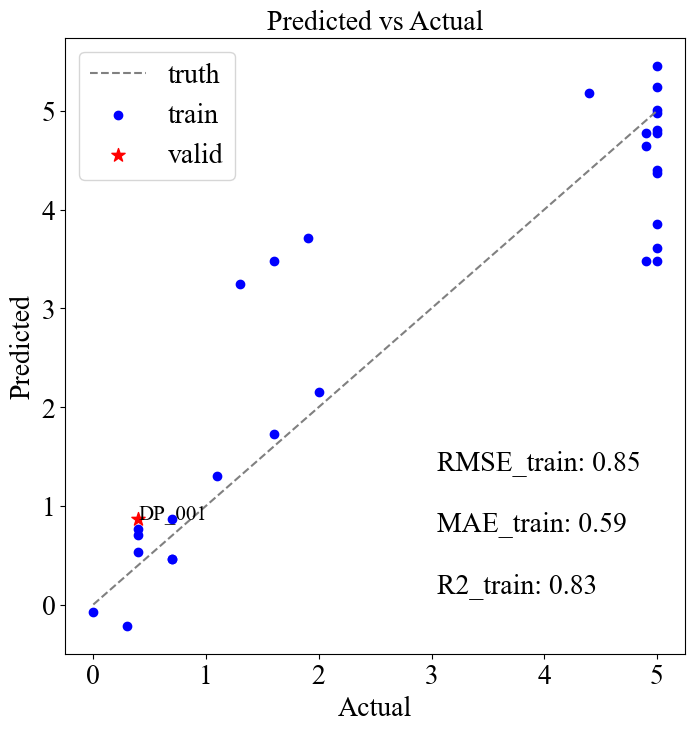

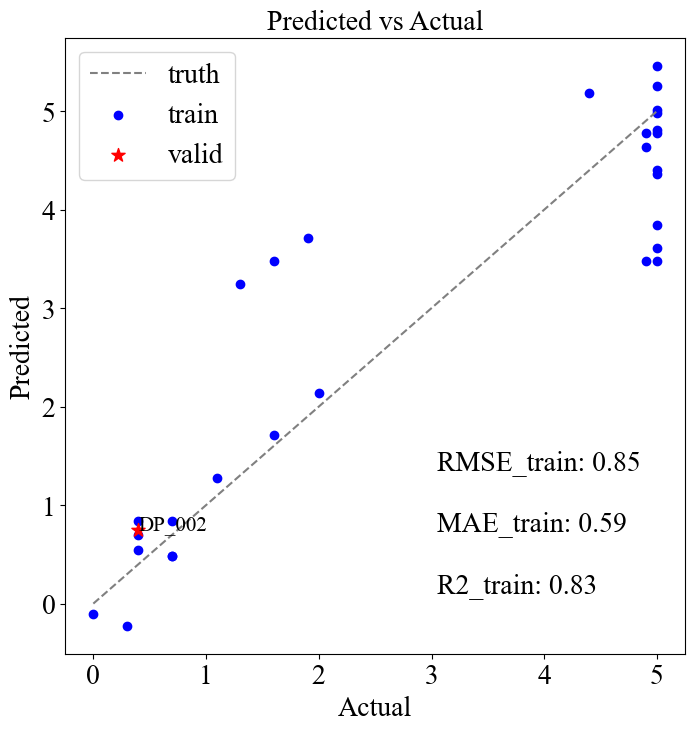

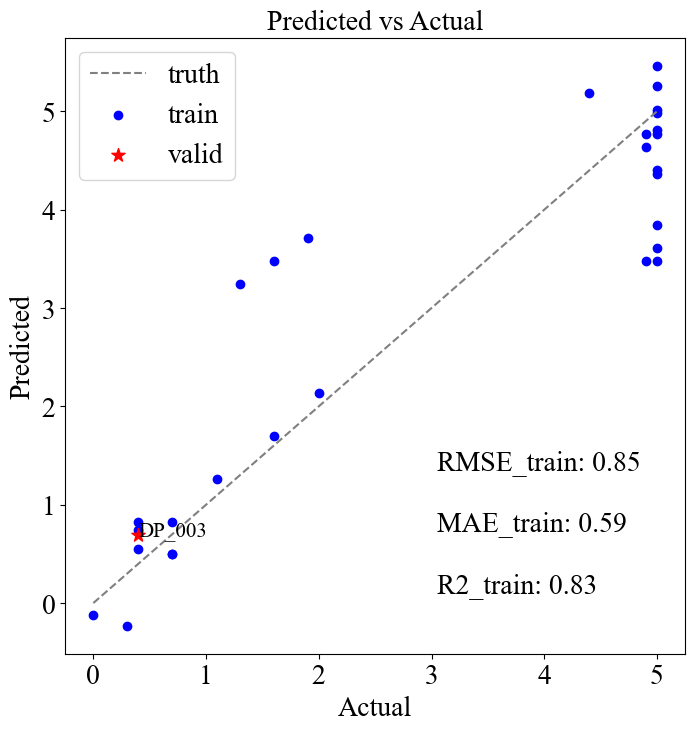

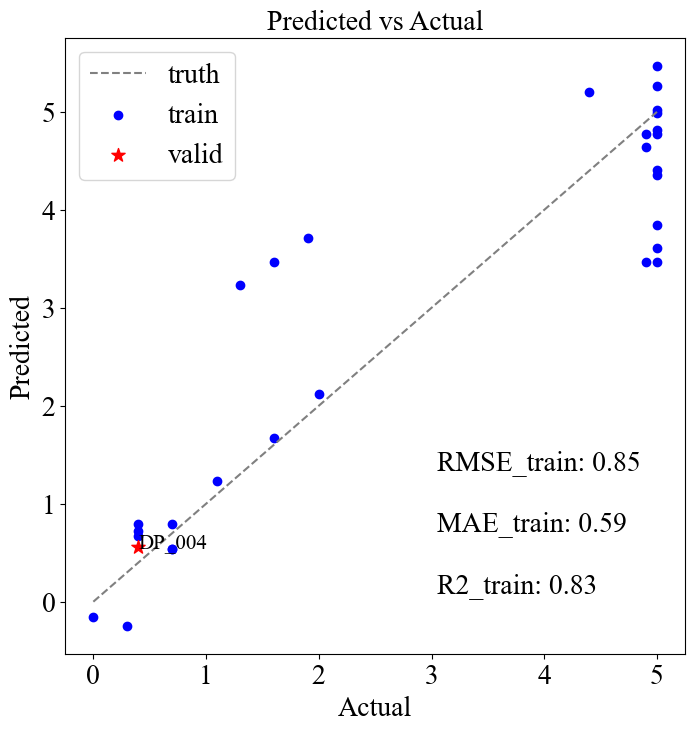

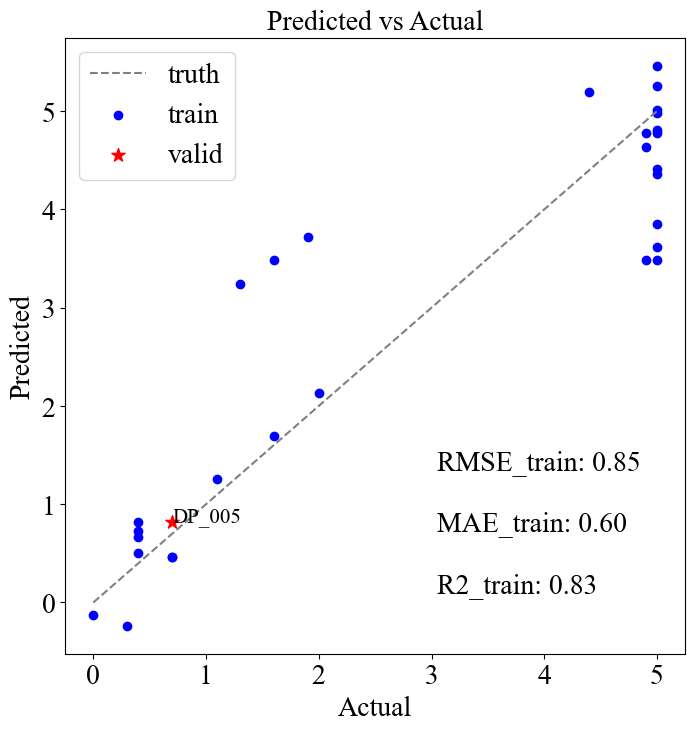

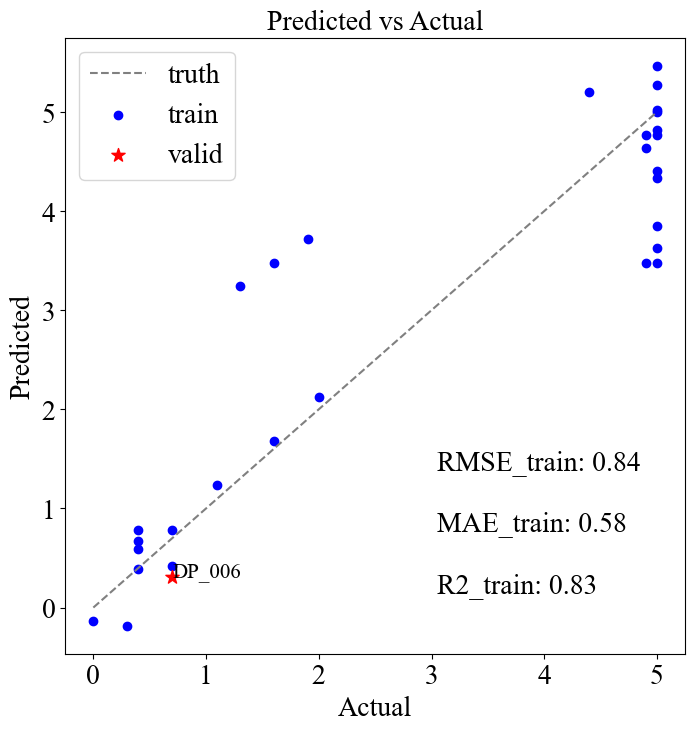

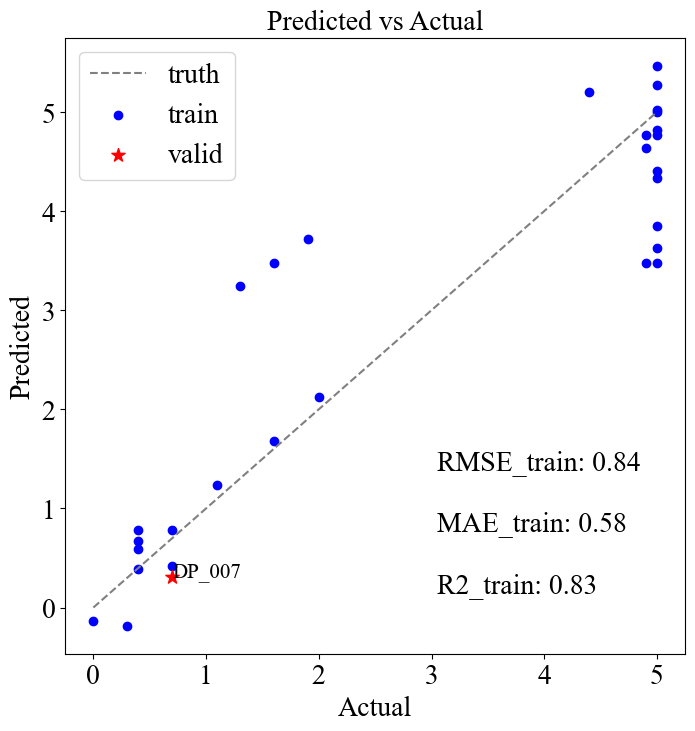

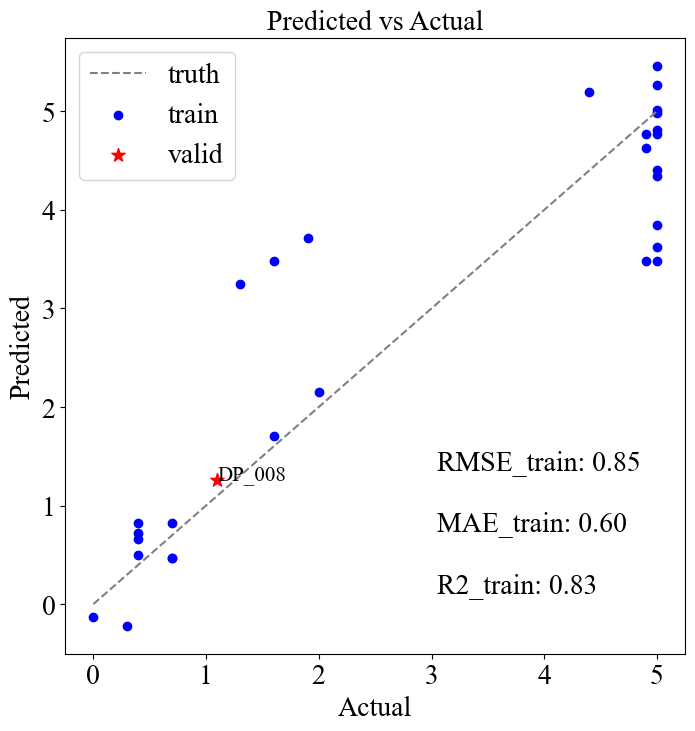

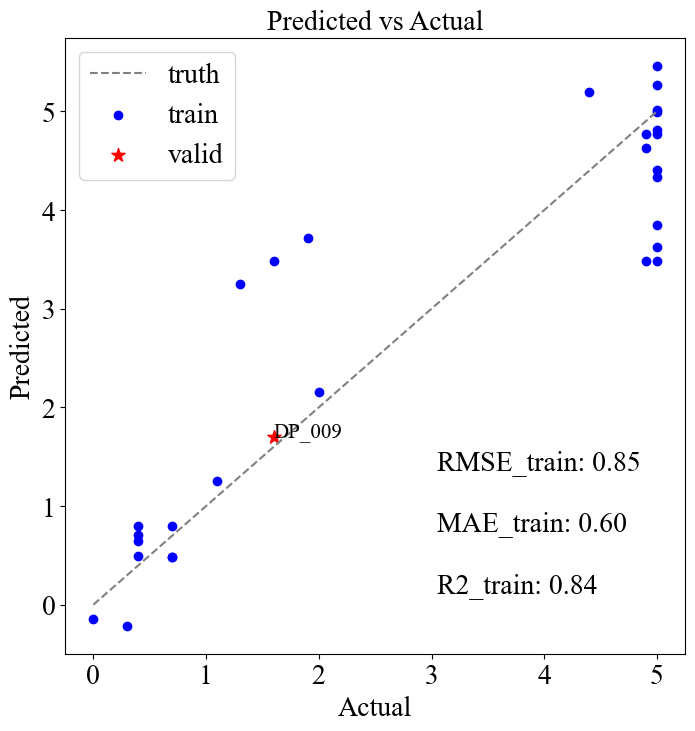

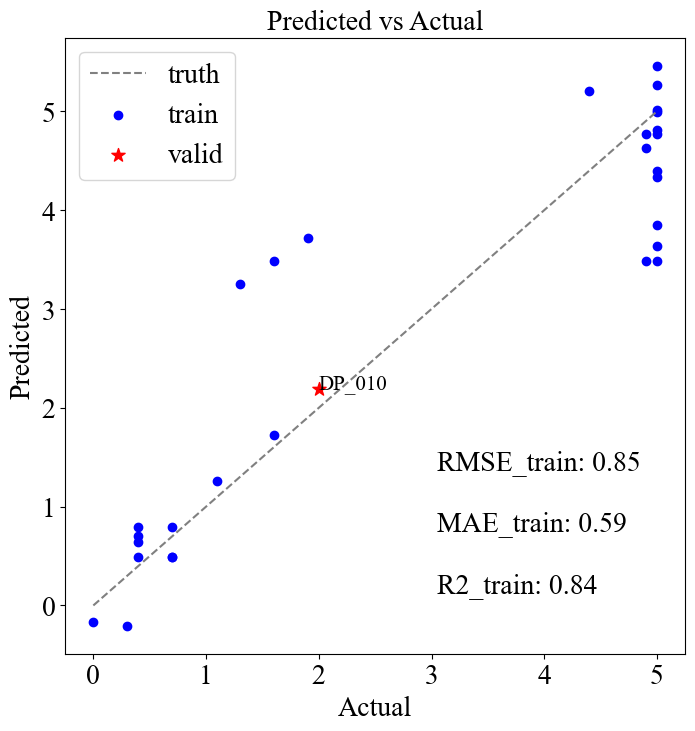

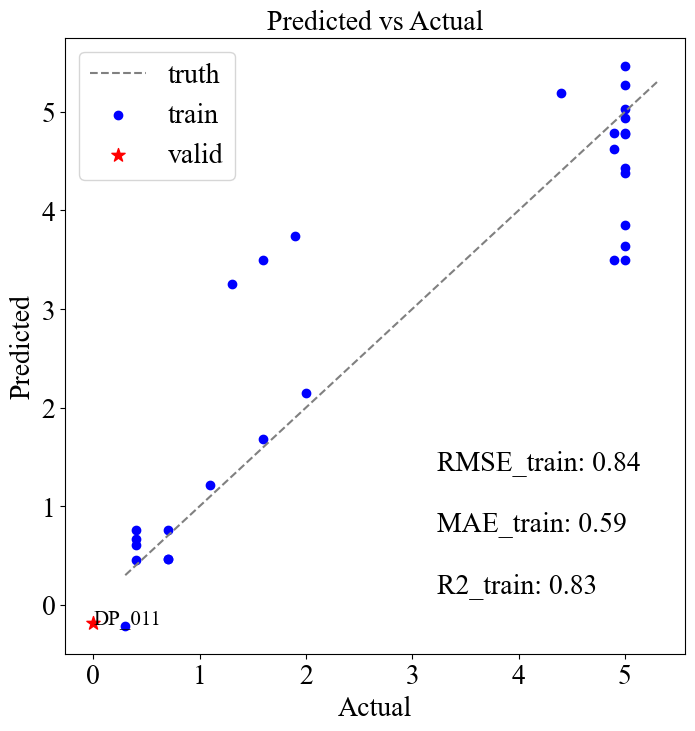

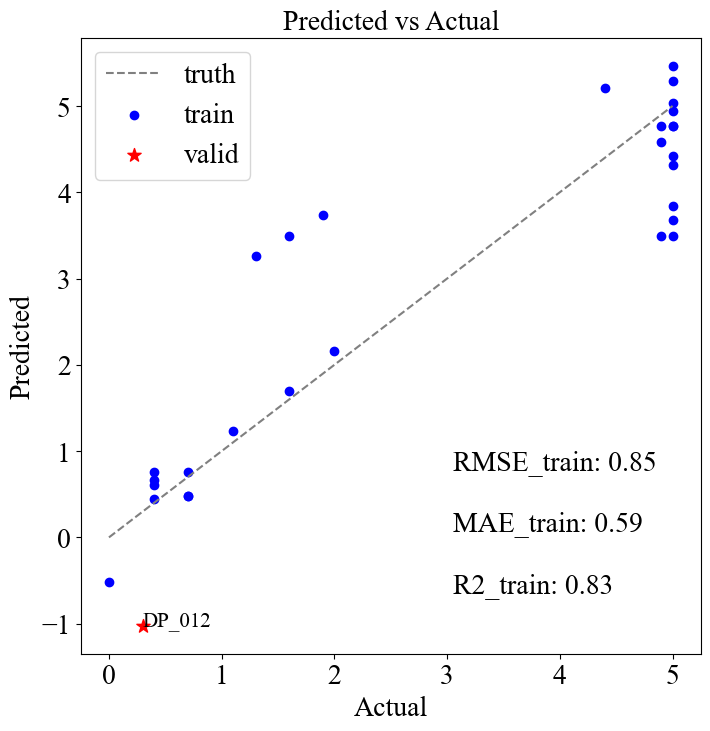

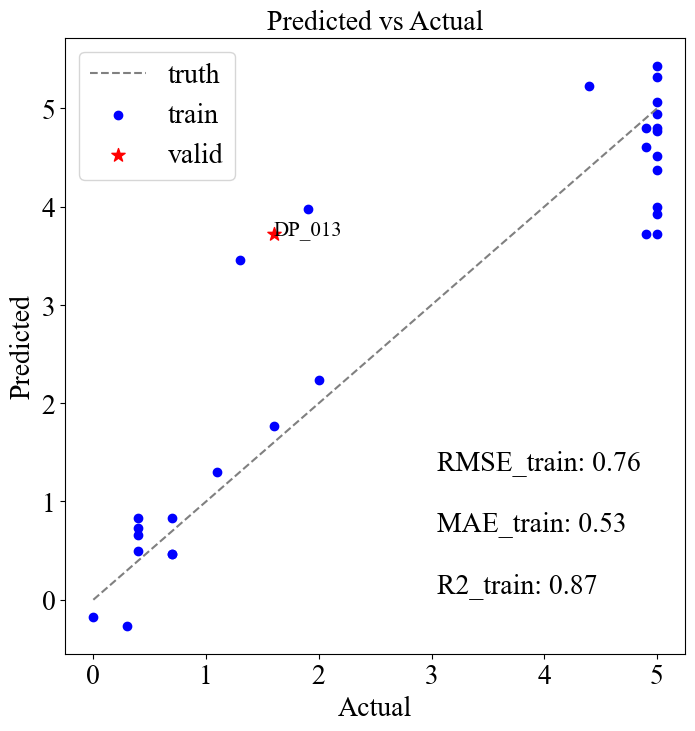

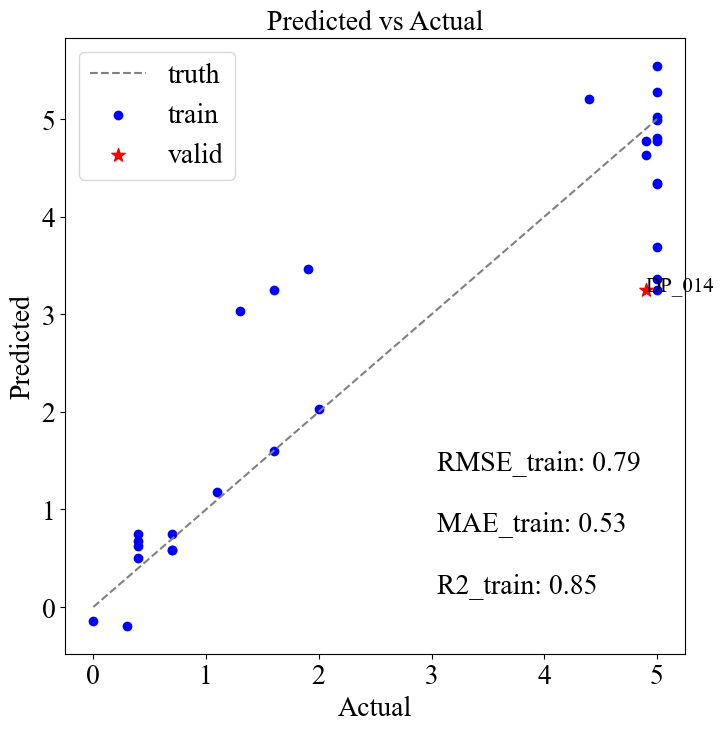

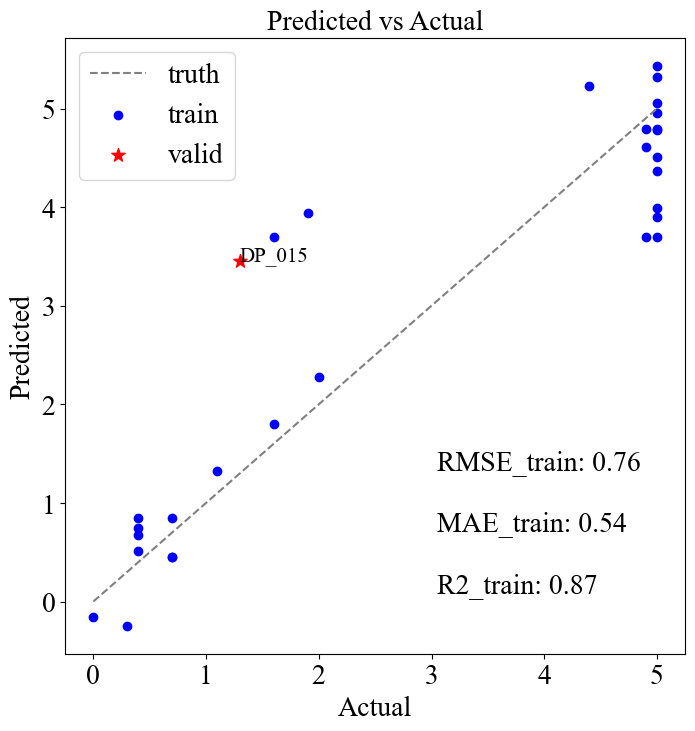

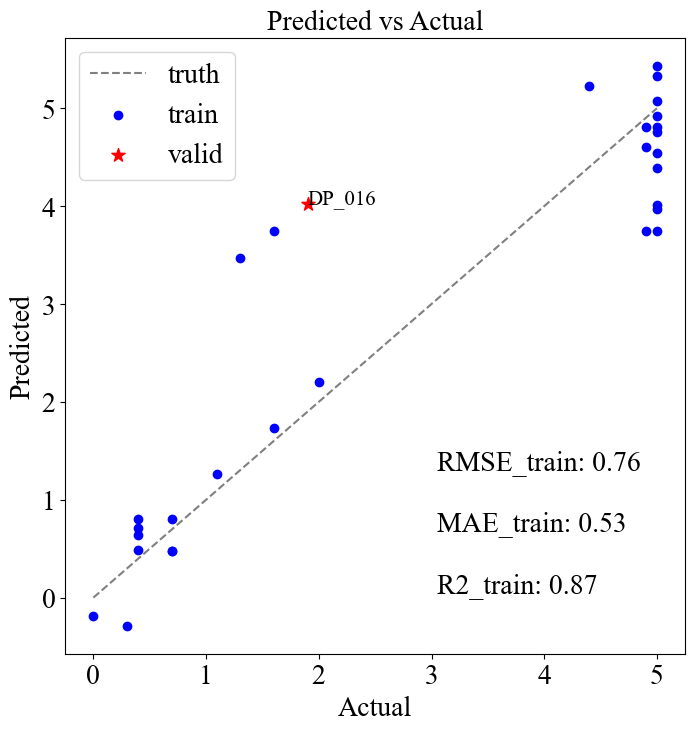

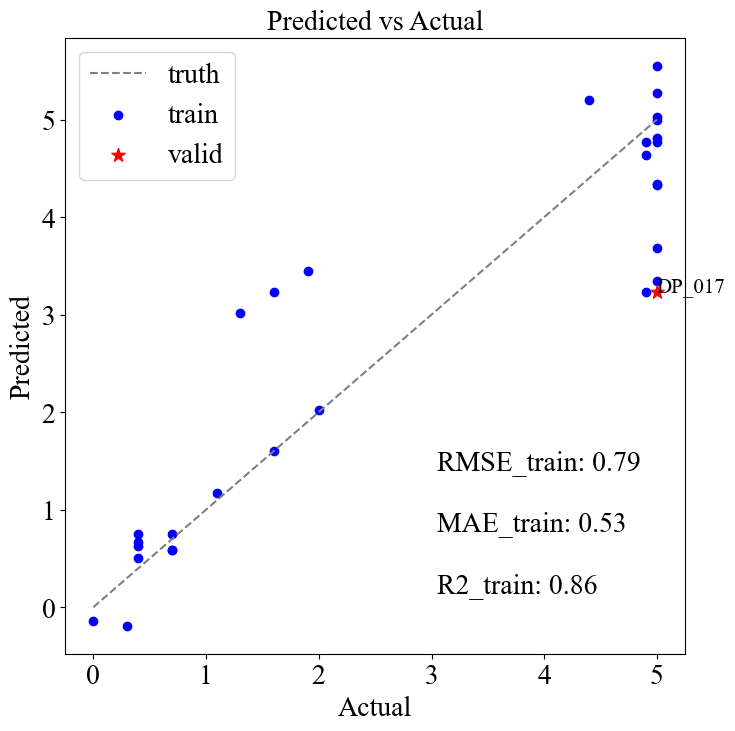

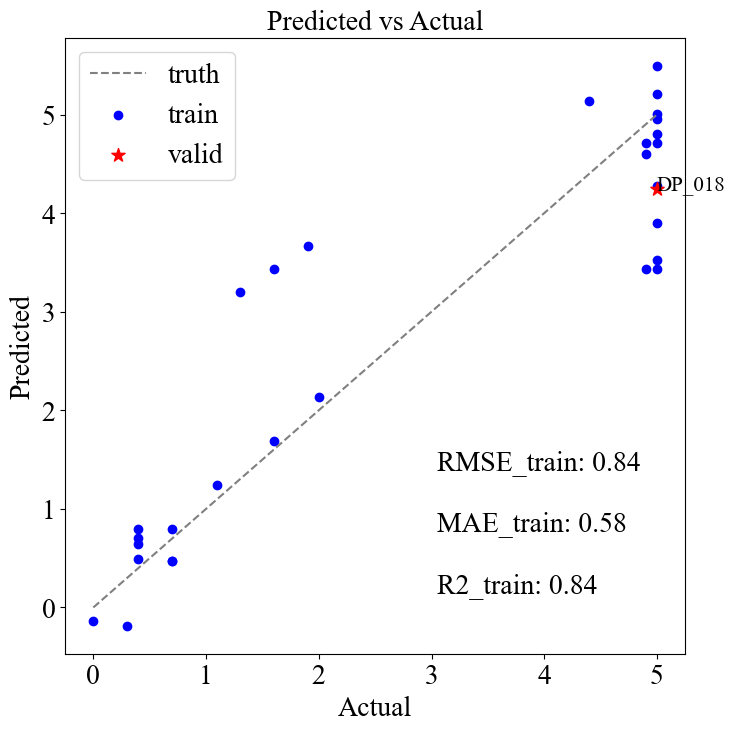

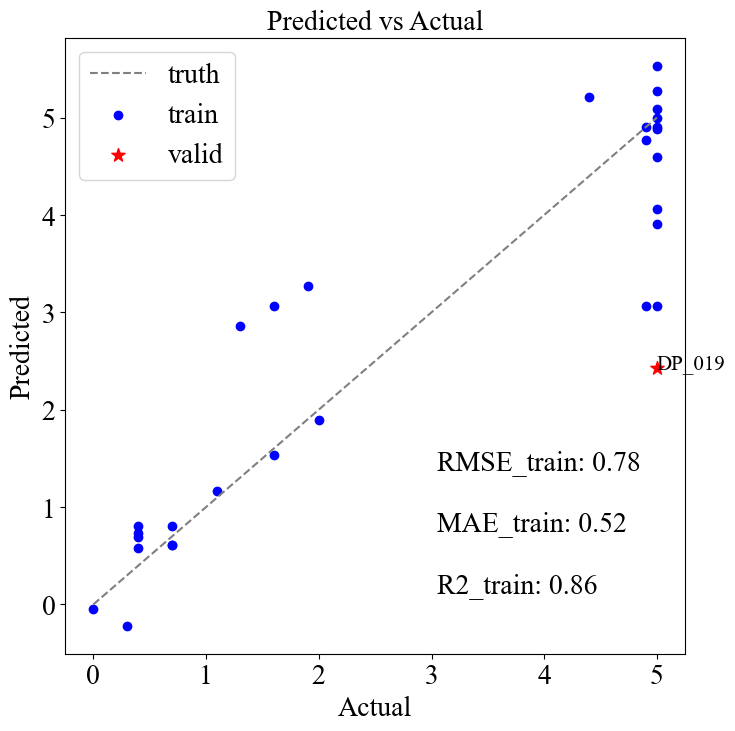

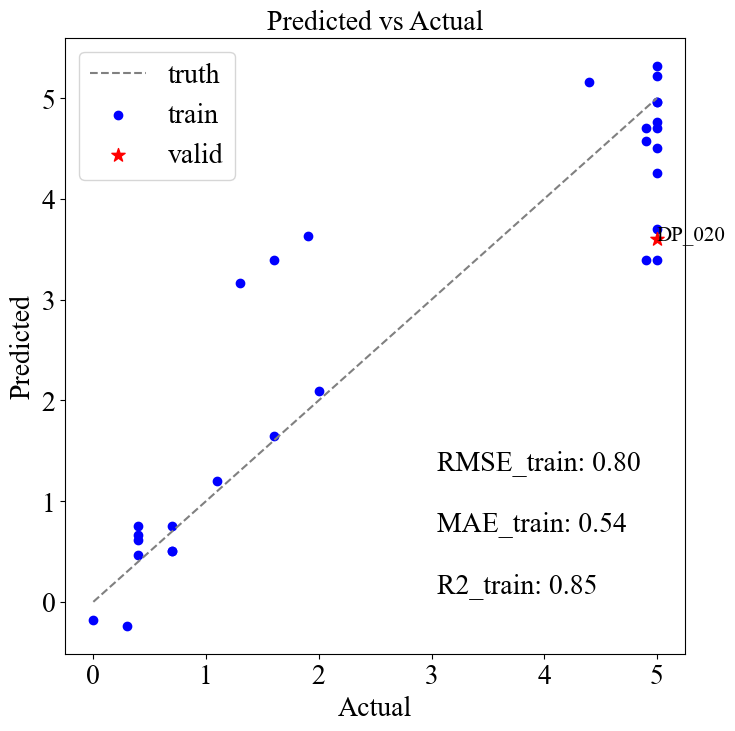

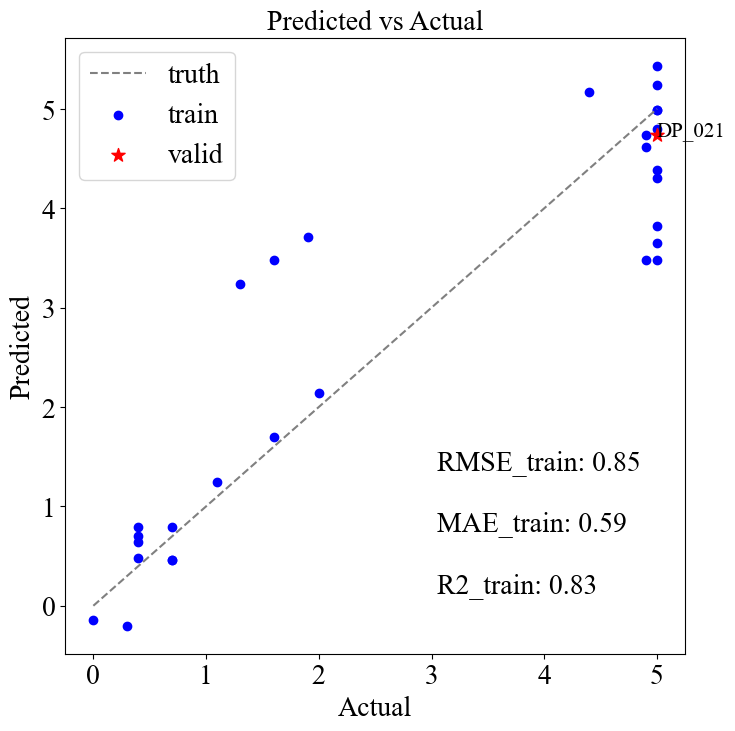

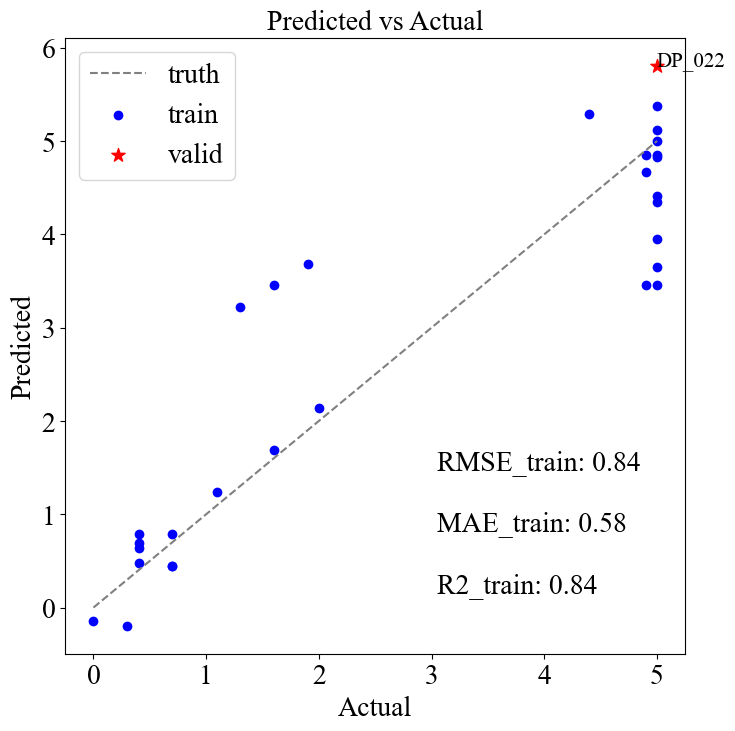

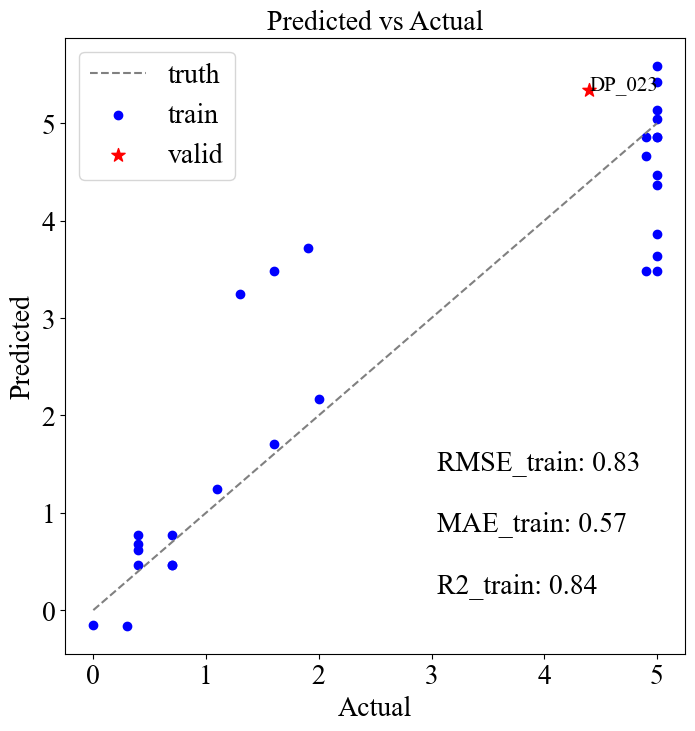

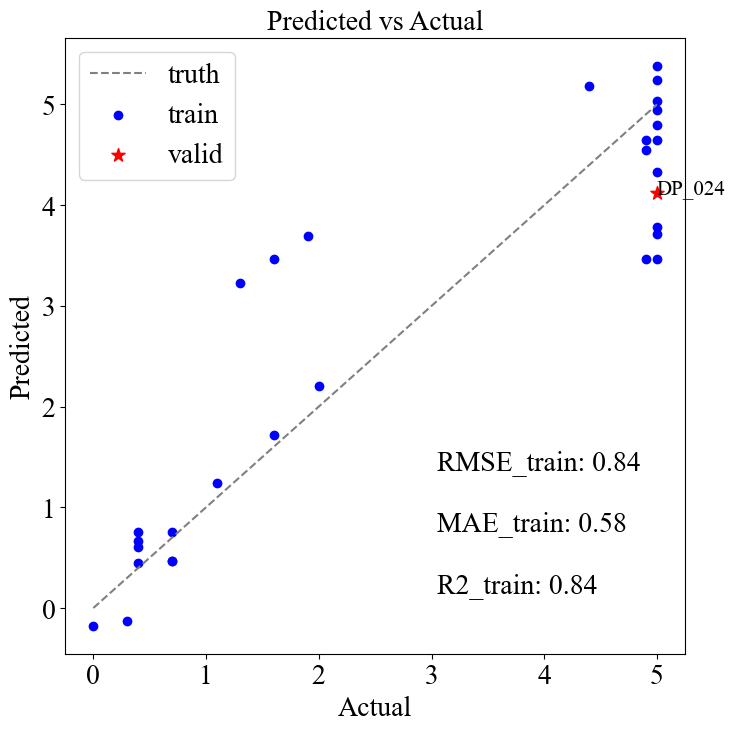

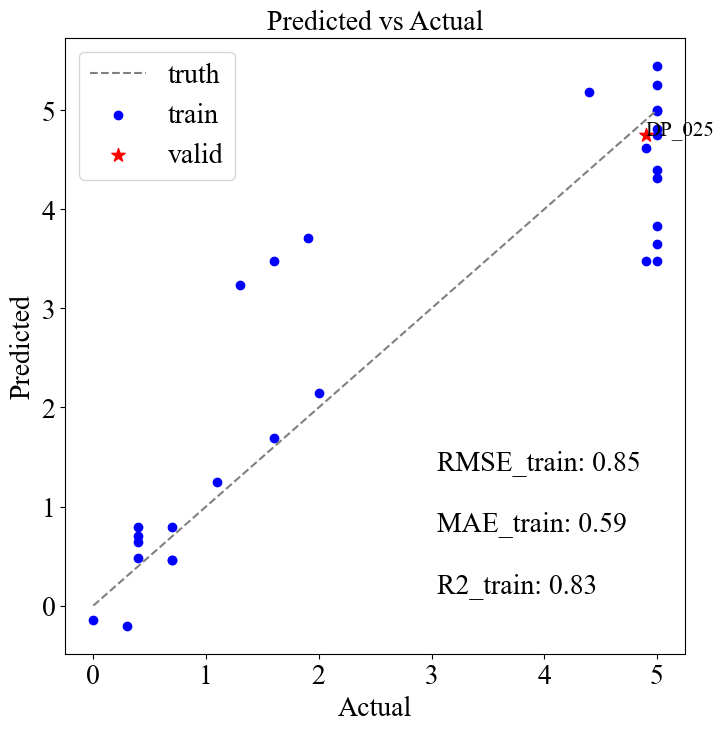

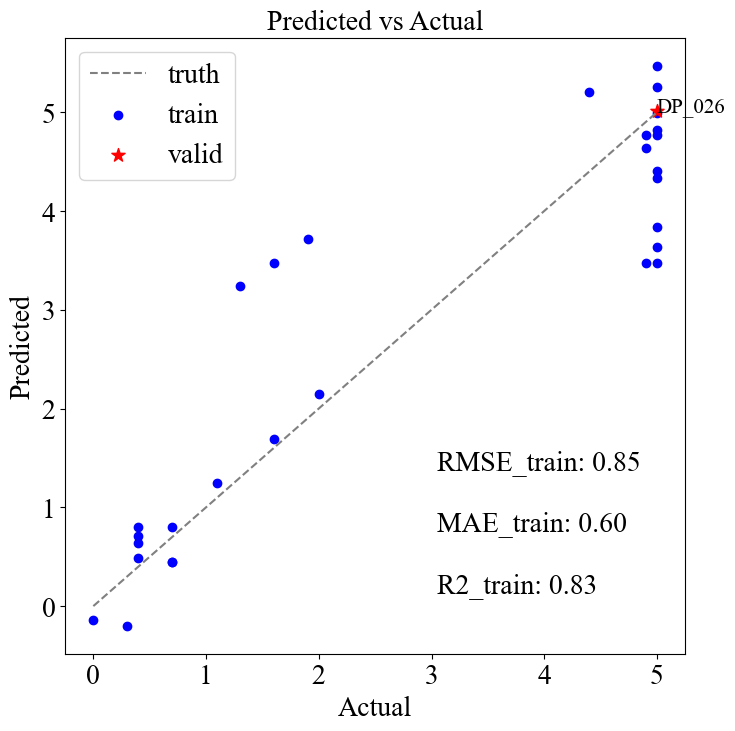

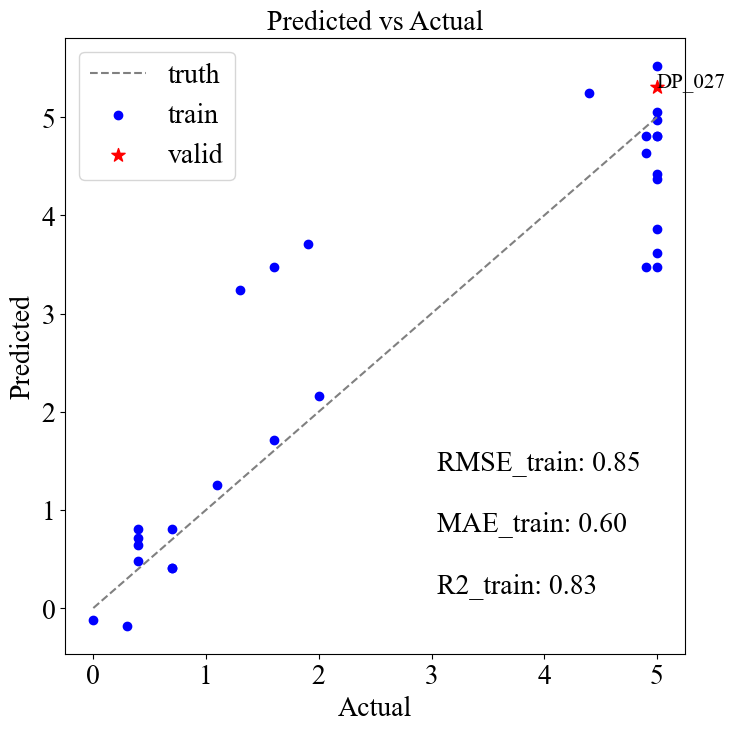

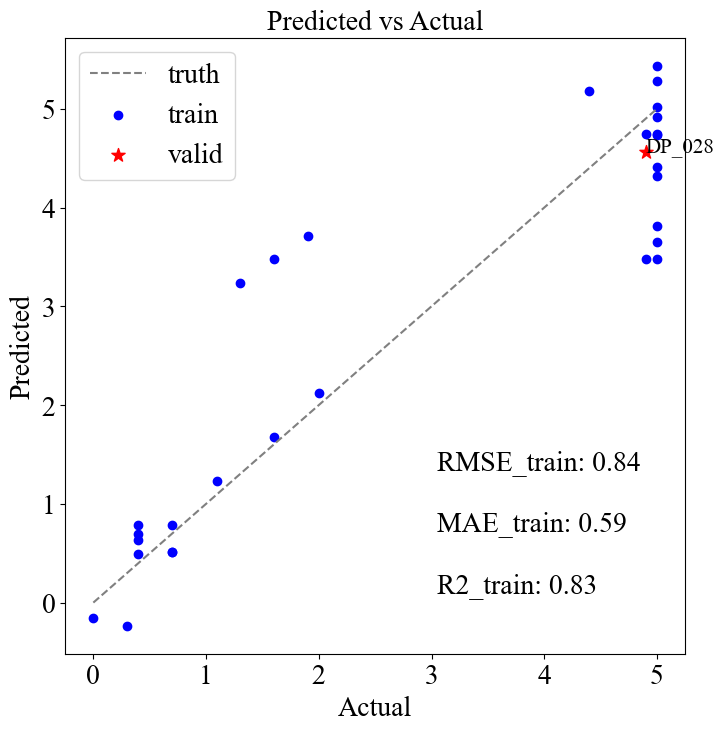

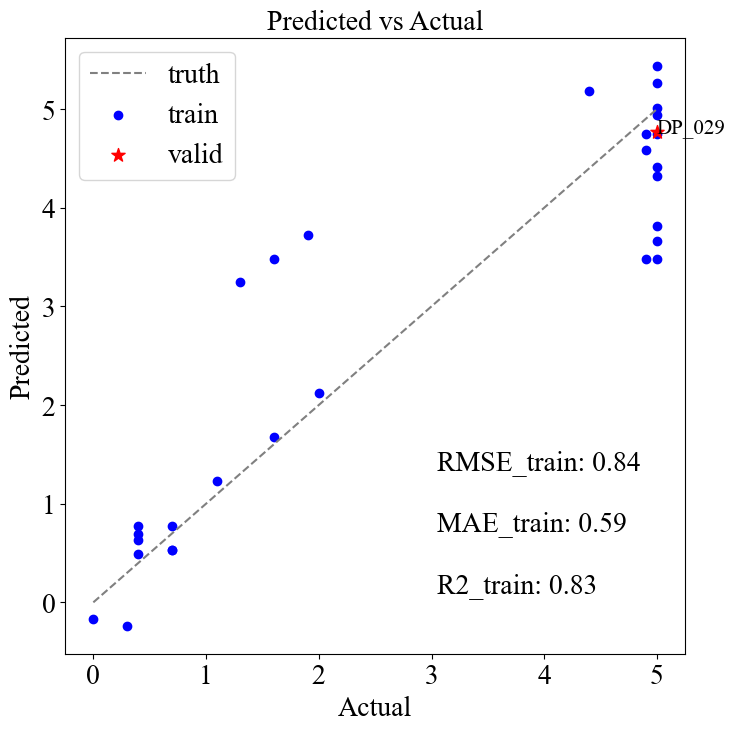

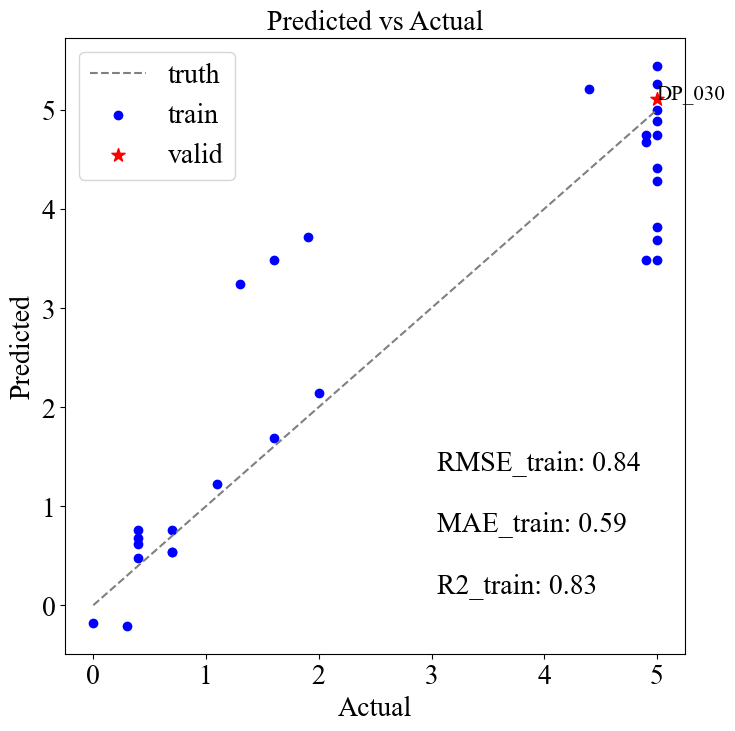

In [35]:
models = []
coef = []
rmses_train = []
maes_train = []
r2_train = []
rmses_valid = []
maes_valid = []
r2_valid = []
oof = np.zeros(len(train_X))

model = PLSRegression(n_components=2)

folds = len(train_X)
kf = KFold(n_splits=folds)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

for train_index, valid_index in tqdm(kf.split(train_X)):
    X_train = scaler_x.fit_transform(train_X.iloc[train_index])
    X_valid = scaler_x.transform(train_X.iloc[valid_index])
    y_train = scaler_y.fit_transform(train_Y.iloc[train_index].values.reshape(-1, 1))
    y_valid = scaler_y.transform(train_Y.iloc[valid_index].values.reshape(-1, 1))

    model.fit(X_train, y_train)
    y_pred_train = scaler_y.inverse_transform(model.predict(X_train).reshape(-1, 1))
    y_pred_valid = scaler_y.inverse_transform(model.predict(X_valid).reshape(-1, 1))

    y_train = scaler_y.inverse_transform(y_train)
    y_valid = scaler_y.inverse_transform(y_valid)

    tmp_rmses_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    tmp_maes_train = mean_absolute_error(y_train, y_pred_train)
    tmp_r2_train = r2_score(y_train, y_pred_train)

    tmp_rmses_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    tmp_maes_valid = mean_absolute_error(y_valid, y_pred_valid)
    tmp_r2_valid = r2_score(y_valid, y_pred_valid)

    print(train_Y.iloc[valid_index].index)
    print("RMSE_train:", tmp_rmses_train)
    print("MAE_train:", tmp_maes_train)
    print("R2_train:", tmp_r2_train)
    # print("RMSE_valid:", tmp_rmses_valid)
    # print("MAE_valid:", tmp_maes_valid)
    # print("R2_valid:", tmp_r2_valid)

    models.append(model)
    coef.append(model.coef_)
    rmses_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    maes_train.append(mean_absolute_error(y_train, y_pred_train))
    r2_train.append(r2_score(y_train, y_pred_train))
    # rmses_valid.append(np.sqrt(mean_squared_error(y_valid, y_pred_valid)))
    # maes_valid.append(mean_absolute_error(y_valid, y_pred_valid))
    # r2_valid.append(r2_score(y_valid, y_pred_valid))

    oof[valid_index] = y_pred_valid

    plt.figure(figsize=(8, 8))
    plt.title('Predicted vs Actual')
    plt.scatter(y_train, y_pred_train, label='train', color='blue')
    plt.scatter(y_valid, y_pred_valid, label='valid', color='red', marker='*', s=100)
    x_truth = np.arange(y_train.min(), y_train.max() +1 )
    y_truth = x_truth
    plt.plot(x_truth, y_truth, '--', color='gray', label='truth')
    # plt.textでRMSE, MAE, R2を右下に表示
    plt.text(0.6, 0.3, f"RMSE_train: {tmp_rmses_train:.2f}", transform=plt.gca().transAxes)
    plt.text(0.6, 0.2, f"MAE_train: {tmp_maes_train:.2f}", transform=plt.gca().transAxes)
    plt.text(0.6, 0.1, f"R2_train: {tmp_r2_train:.2f}", transform=plt.gca().transAxes)
    # plt.txtでvalid_indexに対応するサンプルIDを表示
    for i, txt in enumerate(train_df.iloc[valid_index]['サンプルID']):
        plt.text(y_valid[i], y_pred_valid[i], txt, fontsize=15)

    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()

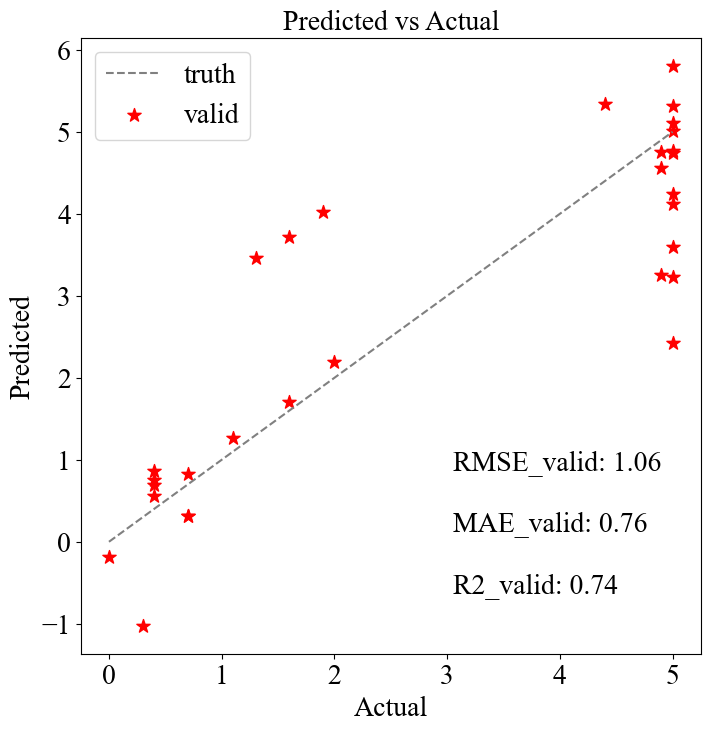

In [48]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title('Predicted vs Actual')
plt.scatter(train_Y, oof, label='valid', color='red', marker='*', s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() +1 )
y_truth = x_truth
plt.plot(x_truth, y_truth, '--', color='gray', label='truth')
plt.xlabel('Actual')
plt.ylabel('Predicted')
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(0.6, 0.3, f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.2, f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes)
plt.legend()

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


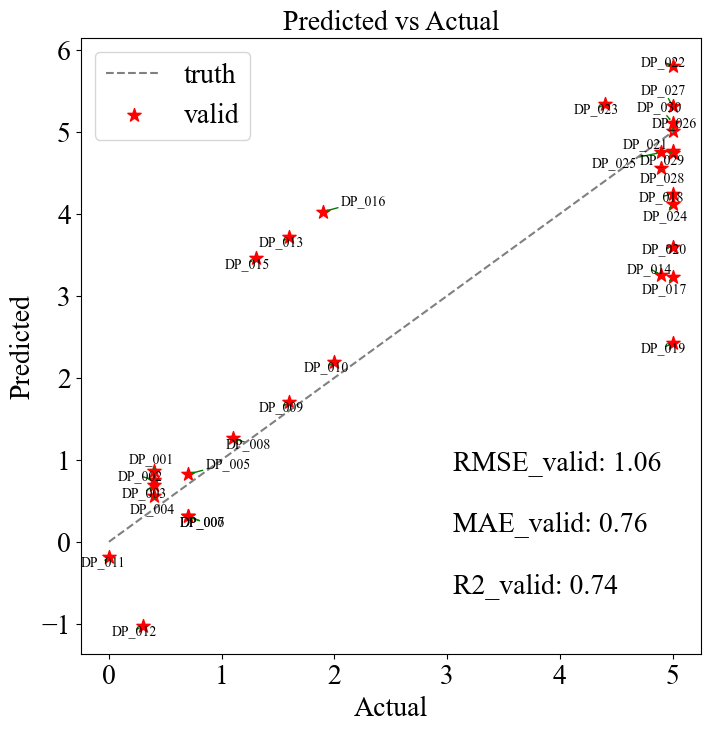

In [47]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title('Predicted vs Actual')
plt.scatter(train_Y, oof, label='valid', color='red', marker='*', s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() +1 )
y_truth = x_truth
plt.plot(x_truth, y_truth, '--', color='gray', label='truth')
plt.xlabel('Actual')
plt.ylabel('Predicted')
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(0.6, 0.3, f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.2, f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes)
# plt.txtでvalid_indexに対応するサンプルIDを表示、adjustTextモジュールを使用して、重なりがないように表示
from adjustText import adjust_text
texts = [plt.text(train_Y.values[i], oof[i], train_df['サンプルID'][i], fontsize=10) for i in range(len(train_Y))]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='green'))
plt.legend()